# Using Tabula Sapiens as a reference for annotating new datasets

This notebook allows you to annotate your data with a number of annotation methods using the Tabula Sapiens dataset as the reference. 

Initial setup: 
1. Make sure GPU is enabled (Runtime -> Change Runtime Type -> Hardware Accelerator -> GPU)
2. We also highly recommend getting Colab PRO for access to a high ram session.


Integration Methods Provided:
- scVI [(Lopez et al. 2018)](https://www.nature.com/articles/s41592-018-0229-2)
- bbKNN [(Polański et al. 2020)](https://academic.oup.com/bioinformatics/article/36/3/964/5545955)
- Scanorama [(He et al. 2019)](https://www.nature.com/articles/s41587-019-0113-3)

Annotation Methods:
- KNN on integrated spaces
- scANVI [(Xu et al. 2021)](https://www.embopress.org/doi/full/10.15252/msb.20209620)
- onClass [(Wang et al. 2020)](https://www.biorxiv.org/content/10.1101/810234v2)
- SVM 
- RandomForest

To use the notebook, simply connect to your Google Drive account, set the necessary arguments, select your methods, and run all the code blocks!

**User action is only required in Steps 1-3.**

Last edited: 6/27/2021



## Step 1: Setup environment

We omit the output of those lines for readability.

In [1]:
%%capture
!git clone --quiet https://github.com/czbiohub/PopV.git

# Restart the Runtime after installation (User Action Required)

Runtime -> "Restart runtime"

In [2]:
%%capture
# Restart the runtime before running this cell
import anndata
import popv
import numpy as np
import scanpy as sc
import os

2023-01-13 20:06:04.347721: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-13 20:06:07.189408: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-13 20:06:07.189677: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-13 20:06:07.189703: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like t

# Step 2: Load your data (User Action Required)
Here we provide three options to load your data:
1. Connect to Google Drive (highly recommended)
2. Download your data from the cloud and save into this session or on Google drive.
3. Upload your data manually into this session (files are not persistent and will be deleted when session is closed)

As an example, we use a subsampled version of the [Lung Cell Atlas](https://hlca.ds.czbiohub.org/) \[1] for our query data.

\[1] Travaglini, K. et al. A molecular cell atlas of the human lung from single-cell RNA sequencing. *Nature* **587**, 619–625(2020).

In [3]:
input_file ={'source': 'wget', 'path': 'LCA.h5ad', 'link': 'https://www.dropbox.com/s/mrf8y7emfupo4he/LCA.h5ad?dl=1'}

if input_file['source']== 'gdrive':
  # OPTION 1: Connect to Google Drive
  # This is the recomended method especially for large datasets
  from google.colab import drive    
  drive.mount('/content/drive')
  query_adata = anndata.read(input_file['path'])
elif input_file['source'] == f
  # OPTION 2: Uploading data manually
  # Click the folder icon on the left navigation bar, and select the upload icon
  # Note: Manually uploaded data is automatically deleted when the colab session ends
  # This is not recommended if your dataset is very large
  query_adata = anndata.read(input_file['path'])
else:
  # OPTION 3: Downloading from the cloud (Dropbox, AWS, Google Drive, etc)
  # Google Colab supports wget, curl, and gdown commands
  # It is recommended to download the data into Google Drive and read from there.
  # This way your data will be persistent.
  print('downloading')
  try:
    !wget -O {input_file['path']} {input_file['link']}
    query_adata = anndata.read(input_file['path'])
  except:
    raise Exception(f'Default download failed with wget. Use custom downloader or check provided link ' + input_file['link'])
    

query_adata.obs_names_make_unique()
query_adata.var_names = query_adata.var_names.str.upper()

SyntaxError: invalid syntax (1913395317.py, line 9)

In [ ]:
query_adata = sc.read('LCA.h5ad')
    
query_adata.obs_names_make_unique()
query_adata.var_names = query_adata.var_names.str.upper()

# Step 3 (User Action Required): Setting Up Annotation Parameters 

Here is where you set the parameters for the automated annotation.

Arguments:
- **tissue:** Tabula Sapiens tissue to annotate your data with. Available tissues: ["Bladder", "Blood", "Bone_Marrow", "Kidney", "Large_Intestine", "Lung","Lymph_Node", "Pancreas", "Small_Intestine", "Spleen", "Thymus","Trachea", "Vasculature"]
- **save_location:** location to save results to. By default will save to a folder named `annotation_results`. It is highly recommended you provide a Google Drive folder here.
- **query_batch_key:** key in `query_adata.obs` for batch correction. Set to None for no batch correction. 
- **algorithms:** these are the methods to run. By default, will run all methods.


Lesser used parameters
- **query_labels_key**: scANVI has the option to use labeled cells in the query dataset during training. To use some prelabeled cells from the query dataset, set `query_labels_key` to the corresponding key in `query_adata.obs`
- **unknown_celltype_label**: If `query_labels_key` is not None, will treat everything not labeled `unknown_celltype_label` as a labeled cell

In [ ]:
""" 
tissue options: 
['Bladder','Blood','Bone_Marrow','Fat',
'Heart','Kidney','Large_Intestine','Liver',
'Lung','Lymph_Node','Mammary','Muscle',
'Pancreas','Prostate','Salivary Gland',
'Skin','Small_Intestine','Spleen',
'Thymus','Trachea','Vasculature']
"""
tissue = 'Lung'
save_folder = 'popv_results'

query_batch_key = 'donor_method'
algorithms = [
    "knn_on_scvi_pred",
    "scanvi_pred",
    "knn_on_bbknn_pred",
    "svm_pred",
    "rf_pred",
    "onclass_pred",
    "knn_on_scanorama_pred",
]

# Lesser used parameters
query_labels_key=None
unknown_celltype_label='unknown'

# Step 4: Downloading Reference Data and Pretrained Models
No more user input required! Just run all the following code blocks.

**NOTE: PopV has only been evaluated with the Lung as a reference dataset. Other tissue results may vary depending on annotation quality**

In [ ]:
# Here we download the necessary data:
if tissue == 'Bladder':
  refdata_url = 'https://www.dropbox.com/s/p5x1lb0jyl8293c/Bladder.h5ad'
  pretrained_url='https://www.dropbox.com/s/2a4cp7d0krp0dxg/Bladder_pretrained_ts.tar.gz'
elif tissue == 'Blood':
  refdata_url = 'https://www.dropbox.com/s/4cg6zj340oelhlg/Blood.h5ad'
  pretrained_url = 'https://www.dropbox.com/s/ls52js43fy7hipf/Blood_pretrained_ts.tar.gz'
elif tissue == 'Bone_Marrow':
  refdata_url = 'https://www.dropbox.com/s/rwfovoyafpd64io/Bone_Marrow.h5ad'
  pretrained_url = 'https://www.dropbox.com/s/wljt0c7c11ng2jk/Bone_Marrow_pretrained_ts.tar.gz'
elif tissue == 'Fat':
  refdata_url = 'https://www.dropbox.com/s/if1d7iloovi8e9o/Fat.h5ad'
  pretrained_url = 'https://www.dropbox.com/s/vuvz1cotuc3wgpr/Fat_pretrained_ts.tar.gz'
elif tissue == 'Heart':
  refdata_url = 'https://www.dropbox.com/s/0udrdzjl2z087jj/Heart.h5ad'
  pretrained_url = 'https://www.dropbox.com/s/5u228dl65stima3/Heart_pretrained_ts.tar.gz'
elif tissue == 'Kidney':
  refdata_url = 'https://www.dropbox.com/s/8sx9fhjfgnyjgdz/Kidney.h5ad'
  pretrained_url = 'https://www.dropbox.com/s/8y30r0rjmwo8jjw/Kidney_pretrained_ts.tar.gz'
elif tissue == 'Large_Intestine':
  refdata_url = 'https://www.dropbox.com/s/272sajn0hkj62le/Large_Intestine.h5ad'
  pretrained_url = 'https://www.dropbox.com/s/rta6qfbor7gjagh/Large_Intestine_pretrained_ts.tar.gz'
elif tissue == 'Liver':
  refdata_url = 'https://www.dropbox.com/s/g0ahumalnm0mp38/Liver.h5ad'
  pretrained_url = 'https://www.dropbox.com/s/u9c7dohzced6335/Liver_pretrained_ts.tar.gz'
elif tissue == 'Lung':
  refdata_url = 'https://www.dropbox.com/s/2kuzdamjevev2ci/Lung.h5ad'
  pretrained_url = 'https://www.dropbox.com/s/katva5lqs74w0cs/Lung_pretrained_ts.tar.gz'
elif tissue == 'Lymph_Node':
  refdata_url = 'https://www.dropbox.com/s/tetuh62010uothb/Lymph_Node.h5ad'
  pretrained_url = 'https://www.dropbox.com/s/hddr9xkocg1a5ws/Lymph_Node_pretrained_ts.tar.gz'
elif tissue == 'Mammary':
  refdata_url = 'https://www.dropbox.com/s/krm4pv4ev6cynns/Mammary.h5ad'
  pretrained_url = 'https://www.dropbox.com/s/6keoifasne094z9/Mammary_pretrained_ts.tar.gz'
elif tissue == 'Muscle':
  refdata_url = 'https://www.dropbox.com/s/0jhvnoy49rvrlqn/Muscle.h5ad'
  pretrained_url = 'https://www.dropbox.com/s/o0po7i5tozewks4/Muscle_pretrained_ts.tar.gz'
elif tissue == 'Pancreas':
  refdata_url = 'https://www.dropbox.com/s/kn0zodnmxwx0yhe/Pancreas.h5ad'
  pretrained_url = 'https://www.dropbox.com/s/c4u1klyg91p2ufm/Pancreas_pretrained_ts.tar.gz'
elif tissue == 'Prostate':
  refdata_url = 'https://www.dropbox.com/s/040fb5jr0zcur7h/Prostate.h5ad'
  pretrained_url = 'https://www.dropbox.com/s/g8epczuui1qi80k/Prostate_pretrained_ts.tar.gz'
elif tissue == 'Salivary_Gland':
  refdata_url = 'https://www.dropbox.com/s/rwia1ji7eztga6b/Salivary_Gland.h5ad'
  pretrained_url = 'https://www.dropbox.com/s/ijwxj3zh3z8gryg/Salivary_Gland_pretrained_ts.tar.gz'
elif tissue == 'Skin':
  refdata_url = 'https://www.dropbox.com/s/ucvdksq2jnug2nh/Skin.h5ad'
  pretrained_url = 'https://www.dropbox.com/s/1jrcmpyqvl409ps/Skin_pretrained_ts.tar.gz'
elif tissue == 'Small_Intestine':
  refdata_url = 'https://www.dropbox.com/s/06ia5n2yex3dq8j/Small_Intestine.h5ad'
  pretrained_url = 'https://www.dropbox.com/s/xj990wl2b9gka52/Small_Intestine_pretrained_ts.tar.gz'
elif tissue == 'Spleen':
  refdata_url = 'https://www.dropbox.com/s/m2d0gme847qdhr1/Spleen.h5ad'
  pretrained_url = 'https://www.dropbox.com/s/cs1xf6w6f4xxfte/Spleen_pretrained_ts.tar.gz'
elif tissue == 'Thymus':
  refdata_url = 'https://www.dropbox.com/s/i84bcyk87scesml/Thymus.h5ad'
  pretrained_url='https://www.dropbox.com/s/fvtlagw5q89mirk/Thymus_pretrained_ts.tar.gz'
elif tissue == 'Trachea':
  refdata_url = 'https://www.dropbox.com/s/ppt7b6w73gvceap/Trachea.h5ad'
  pretrained_url = 'https://www.dropbox.com/s/bwkds6e46id2b0b/Trachea_pretrained_ts.tar.gz'
elif tissue == 'Vasculature':
  refdata_url = 'https://www.dropbox.com/s/1eq0zamel5etmoq/Vasculature.h5ad'
  pretrained_url='https://www.dropbox.com/s/uvakps392265wt4/Vasculature_pretrained_ts.tar.gz'

# Download reference dataset
output_fn = 'TS_{}.h5ad'.format(tissue)
!wget -O $output_fn $refdata_url

# Download pretrained scVI and scANVI models.
output_fn = '{}.tar.gz'.format(tissue)
if not os.path.exists('pretrained_models'):
   os.makedirs('pretrained_models')
!wget -O $output_fn $pretrained_url
!tar -C pretrained_models -xvzf $output_fn

--2023-01-13 14:11:27--  https://www.dropbox.com/s/2kuzdamjevev2ci/Lung.h5ad
Resolving www.dropbox.com (www.dropbox.com)... 162.125.7.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.7.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/2kuzdamjevev2ci/Lung.h5ad [following]
--2023-01-13 14:11:27--  https://www.dropbox.com/s/raw/2kuzdamjevev2ci/Lung.h5ad
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5b086bc2d0daa3799595fbb106.dl.dropboxusercontent.com/cd/0/inline/B0j41pdb_ldAFzGA_Hps-rdFRqejKAZOxzcKyh17Cv8KHlJjNNAFhCctrltybDPEiwZfeU7BtqabDhmw5ORL6yzjr7eSIuHip727Gf4kSRSG7208GagCVW0KouhIGb-bFvLUdz3QQVbsWtTmoosZEY1M4uZumJypHbSsjmrMglglvw/file# [following]
--2023-01-13 14:11:27--  https://uc5b086bc2d0daa3799595fbb106.dl.dropboxusercontent.com/cd/0/inline/B0j41pdb_ldAFzGA_Hps-rdFRqejKAZOxzcKyh17Cv8KHlJjNNAFhCctrltybDPEiwZfeU7BtqabDhmw5ORL6yzjr

In [ ]:
# read in the reference dataset
ref_adata_path = 'TS_{}.h5ad'.format(tissue)
ref_adata = anndata.read(ref_adata_path)

### Setup reference data

In [ ]:
# Following parameters are specific to Tabula Sapiens dataset and contain the annotated cell-type and the batch_key that are corrected for during model training.
ref_labels_key="cell_ontology_class"
ref_batch_key = ["donor", "method", "10X_run"]

In [ ]:
min_celltype_size = np.min(ref_adata.obs.groupby(ref_labels_key).size())
n_samples_per_label = np.max((min_celltype_size, 500))

### Check if we can use pretrained models

In [ ]:
pretrained_scanvi_path = None # os.path.join("pretrained_models", '{}_pretrained_scanvi'.format(tissue))
pretrained_scvi_path = None # os.path.join("pretrained_models", '{}_pretrained_scvi'.format(tissue))

### Preprocess query with ref dataset


In [ ]:
from popv.preprocessing import Process_Query

adata = Process_Query(
        query_adata,
        ref_adata,
        save_folder=save_folder,
        query_batch_key=query_batch_key,
        query_labels_key=query_labels_key,
        ref_labels_key=ref_labels_key,
        ref_batch_key=ref_batch_key,
        unknown_celltype_label=unknown_celltype_label,
        pretrained_scvi_path=pretrained_scvi_path,
        pretrained_scanvi_path=pretrained_scanvi_path,
        n_samples_per_label=n_samples_per_label,
        use_gpu=True
    ).adata

/home/eecs/cergen/anaconda3/envs/PopV/lib/python3.8/site-packages/anndata/_core/merge.py:942: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


# Step 5: Run Automated Cell Annotation Methods
No user action required. 

Your results will be saved to the folder you provided as **save_folder**.

All results are stored in adata.obs
- The column `popv_prediction` contains the end popv prediction. 
- `popv_prediction_score` contains the score for the popv_prediction, which is a measure of the number of methods that agreed with the resulting prediction. We use the cell ontology when aggregating results.
- We also include the majority vote, which simply takes the celltype that was most often predicted by the individual methods.

In [ ]:
from popv.annotation import annotate_data

annotate_data(adata, save_path=save_folder)

/home/eecs/cergen/anaconda3/envs/PopV/lib/python3.8/site-packages/sklearn/neighbors/_base.py:175: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn('Precomputed sparse input was not sorted by data.',
/home/eecs/cergen/anaconda3/envs/PopV/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Found 4000 genes among all datasets
[[0.00000000e+00 7.95084023e-02 4.60796388e-01 1.34433242e-02
  6.87089491e-01 6.97999069e-03 2.11412151e-02 2.93577982e-02
  9.25925926e-04 3.66972477e-03 3.48330914e-02 2.08333333e-02
  1.33185350e-02]
 [0.00000000e+00 0.00000000e+00 7.44920993e-02 5.35288726e-01
  7.17331327e-02 6.82177757e-01 5.66842237e-02 1.37614679e-02
  0.00000000e+00 1.75570604e-03 4.04934688e-01 8.32706295e-02
  2.97447281e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.82309808e-01
  4.17585253e-01 1.20986505e-02 1.40059157e-01 8.07339450e-02
  6.48148148e-03 1.74311927e-02 1.72714078e-01 4.99042535e-02
  2.10876804e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.90253590e-02 5.90041880e-01 1.06935533e-02 1.83486239e-03
  0.00000000e+00 0.00000000e+00 4.04934688e-01 3.05530095e-03
  9.98890122e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 2.16845044e-01 2.55735870e-01 9.35779817e-02
  1.11111111e-02 2.06422

/home/eecs/cergen/anaconda3/envs/PopV/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Epoch 36/36: 100%|██████████| 36/36 [09:58<00:00, 13.99s/it, loss=1.63e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=36` reached.


Epoch 36/36: 100%|██████████| 36/36 [09:58<00:00, 16.62s/it, loss=1.63e+03, v_num=1]


/home/eecs/cergen/anaconda3/envs/PopV/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Training cost after epoch 1: loss:5.022256 acc: 0.967 auc: 1.000 auprc: 0.977


/home/eecs/cergen/anaconda3/envs/PopV/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Training cost after epoch 2: loss:2.310894 acc: 0.985 auc: 1.000 auprc: 0.998


/home/eecs/cergen/anaconda3/envs/PopV/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Training cost after epoch 3: loss:1.490944 acc: 0.988 auc: 1.000 auprc: 1.000


/home/eecs/cergen/anaconda3/envs/PopV/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Training cost after epoch 4: loss:1.049421 acc: 0.994 auc: 1.000 auprc: 1.000


/home/eecs/cergen/anaconda3/envs/PopV/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Training cost after epoch 5: loss:0.761100 acc: 0.997 auc: 1.000 auprc: 1.000


/home/eecs/cergen/anaconda3/envs/PopV/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Training cost after epoch 6: loss:0.567753 acc: 0.996 auc: 1.000 auprc: 1.000


/home/eecs/cergen/anaconda3/envs/PopV/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Training cost after epoch 7: loss:0.437389 acc: 0.997 auc: 1.000 auprc: 1.000


/home/eecs/cergen/anaconda3/envs/PopV/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Training cost after epoch 8: loss:0.348742 acc: 0.996 auc: 1.000 auprc: 1.000


/home/eecs/cergen/anaconda3/envs/PopV/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Training cost after epoch 9: loss:0.287112 acc: 0.998 auc: 1.000 auprc: 1.000


/home/eecs/cergen/anaconda3/envs/PopV/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Training cost after epoch 10: loss:0.244858 acc: 0.997 auc: 1.000 auprc: 1.000


/home/eecs/cergen/anaconda3/envs/PopV/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Training cost after epoch 11: loss:0.210923 acc: 0.997 auc: 1.000 auprc: 1.000


/home/eecs/cergen/anaconda3/envs/PopV/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Training cost after epoch 12: loss:0.188539 acc: 0.996 auc: 1.000 auprc: 1.000


/home/eecs/cergen/anaconda3/envs/PopV/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Training cost after epoch 13: loss:0.171882 acc: 0.997 auc: 1.000 auprc: 1.000


/home/eecs/cergen/anaconda3/envs/PopV/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Training cost after epoch 14: loss:0.157610 acc: 0.993 auc: 1.000 auprc: 1.000


/home/eecs/cergen/anaconda3/envs/PopV/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Training cost after epoch 15: loss:0.154080 acc: 0.997 auc: 1.000 auprc: 1.000


/home/eecs/cergen/anaconda3/envs/PopV/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Training cost after epoch 16: loss:0.145624 acc: 0.993 auc: 1.000 auprc: 1.000


/home/eecs/cergen/anaconda3/envs/PopV/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Training cost after epoch 17: loss:0.144323 acc: 0.994 auc: 1.000 auprc: 1.000


/home/eecs/cergen/anaconda3/envs/PopV/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Training cost after epoch 18: loss:0.137638 acc: 0.999 auc: 1.000 auprc: 1.000


/home/eecs/cergen/anaconda3/envs/PopV/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Training cost after epoch 19: loss:0.133389 acc: 0.992 auc: 1.000 auprc: 1.000


/home/eecs/cergen/anaconda3/envs/PopV/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Training cost after epoch 20: loss:0.133502 acc: 0.994 auc: 1.000 auprc: 1.000


/home/eecs/cergen/anaconda3/envs/PopV/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Training cost after epoch 21: loss:0.131692 acc: 0.996 auc: 1.000 auprc: 1.000


/home/eecs/cergen/anaconda3/envs/PopV/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Training cost after epoch 22: loss:0.129660 acc: 0.997 auc: 1.000 auprc: 1.000


/home/eecs/cergen/anaconda3/envs/PopV/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Training cost after epoch 23: loss:0.130685 acc: 0.996 auc: 1.000 auprc: 1.000


/home/eecs/cergen/anaconda3/envs/PopV/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Training cost after epoch 24: loss:0.128860 acc: 0.996 auc: 1.000 auprc: 1.000


/home/eecs/cergen/anaconda3/envs/PopV/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Training cost after epoch 25: loss:0.126765 acc: 0.995 auc: 1.000 auprc: 1.000


/home/eecs/cergen/anaconda3/envs/PopV/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Training cost after epoch 26: loss:0.128488 acc: 0.997 auc: 1.000 auprc: 1.000


/home/eecs/cergen/anaconda3/envs/PopV/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Training cost after epoch 27: loss:0.125904 acc: 0.997 auc: 1.000 auprc: 1.000


/home/eecs/cergen/anaconda3/envs/PopV/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Training cost after epoch 28: loss:0.123982 acc: 0.998 auc: 1.000 auprc: 1.000


/home/eecs/cergen/anaconda3/envs/PopV/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Training cost after epoch 29: loss:0.126144 acc: 0.997 auc: 1.000 auprc: 1.000


/home/eecs/cergen/anaconda3/envs/PopV/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Training cost after epoch 30: loss:0.122135 acc: 0.998 auc: 1.000 auprc: 1.000


/home/eecs/cergen/anaconda3/envs/PopV/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/eecs/cergen/anaconda3/envs/PopV/lib/python3.8/site-packages/scvi/model/base/_training_mixin.py:60: UserWarning: max_epochs=18 is less than n_epochs_kl_warmup=20. The max_kl_weight will not be reached during training.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Epoch 18/18: 100%|██████████| 18/18 [04:49<00:00, 15.70s/it, loss=1.67e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=18` reached.


Epoch 18/18: 100%|██████████| 18/18 [04:49<00:00, 16.08s/it, loss=1.67e+03, v_num=1]
INFO     Training for 20 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Epoch 20/20: 100%|██████████| 20/20 [03:41<00:00, 11.03s/it, loss=1.79e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [03:41<00:00, 11.07s/it, loss=1.79e+03, v_num=1]



# Optional: save the full anndata will all objects

In [ ]:
adata

AnnData object with n_obs × n_vars = 110753 × 4000
    obs: '10X_run', 'pilot', 'tissue', 'subtissue', 'method', '10X_sample', '10X_replicate', 'notes', 'seqrun', 'donor', 'anatomical_position', '10X_barcode', 'cDNAplate', 'libraryplate', 'well', 'donor_method', 'computational_compartment_assignment', 'tissue_cell_type', 'cell_type_tissue', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', '_batch_annotation', '_labels_annotation', '_ref_subsample', 'cell_ontology_type', 'cell_ontology_id', '_dataset', 'n_counts', 'popv_knn_on_bbknn_prediction', 'popv_knn_on_scanorama_prediction', '_scvi_batch', '_scvi_labels', 'popv_knn_on_scvi_prediction', '_labels_annotation_cell_ontology_id', 'popv_onclass_prediction', 'popv_rf_prediction', 'subsampled_labels', 'popv_scanvi_prediction', 'popv_svm_prediction', 'popv_majority_vote_prediction', 'popv_majority_vote_score', 'popv_prediction', 'popv_prediction_score', 'popv_prediction_depth'
    var: 'n_counts', 'highly_varia

In [ ]:
# adata.write('query_and_reference_popv.h5ad')

/home/eecs/cergen/anaconda3/envs/PopV/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/eecs/cergen/anaconda3/envs/PopV/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/eecs/cergen/anaconda3/envs/PopV/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/eecs/cergen/anaconda3/envs/PopV/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/eecs/cergen/anaconda3/envs/PopV/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data f

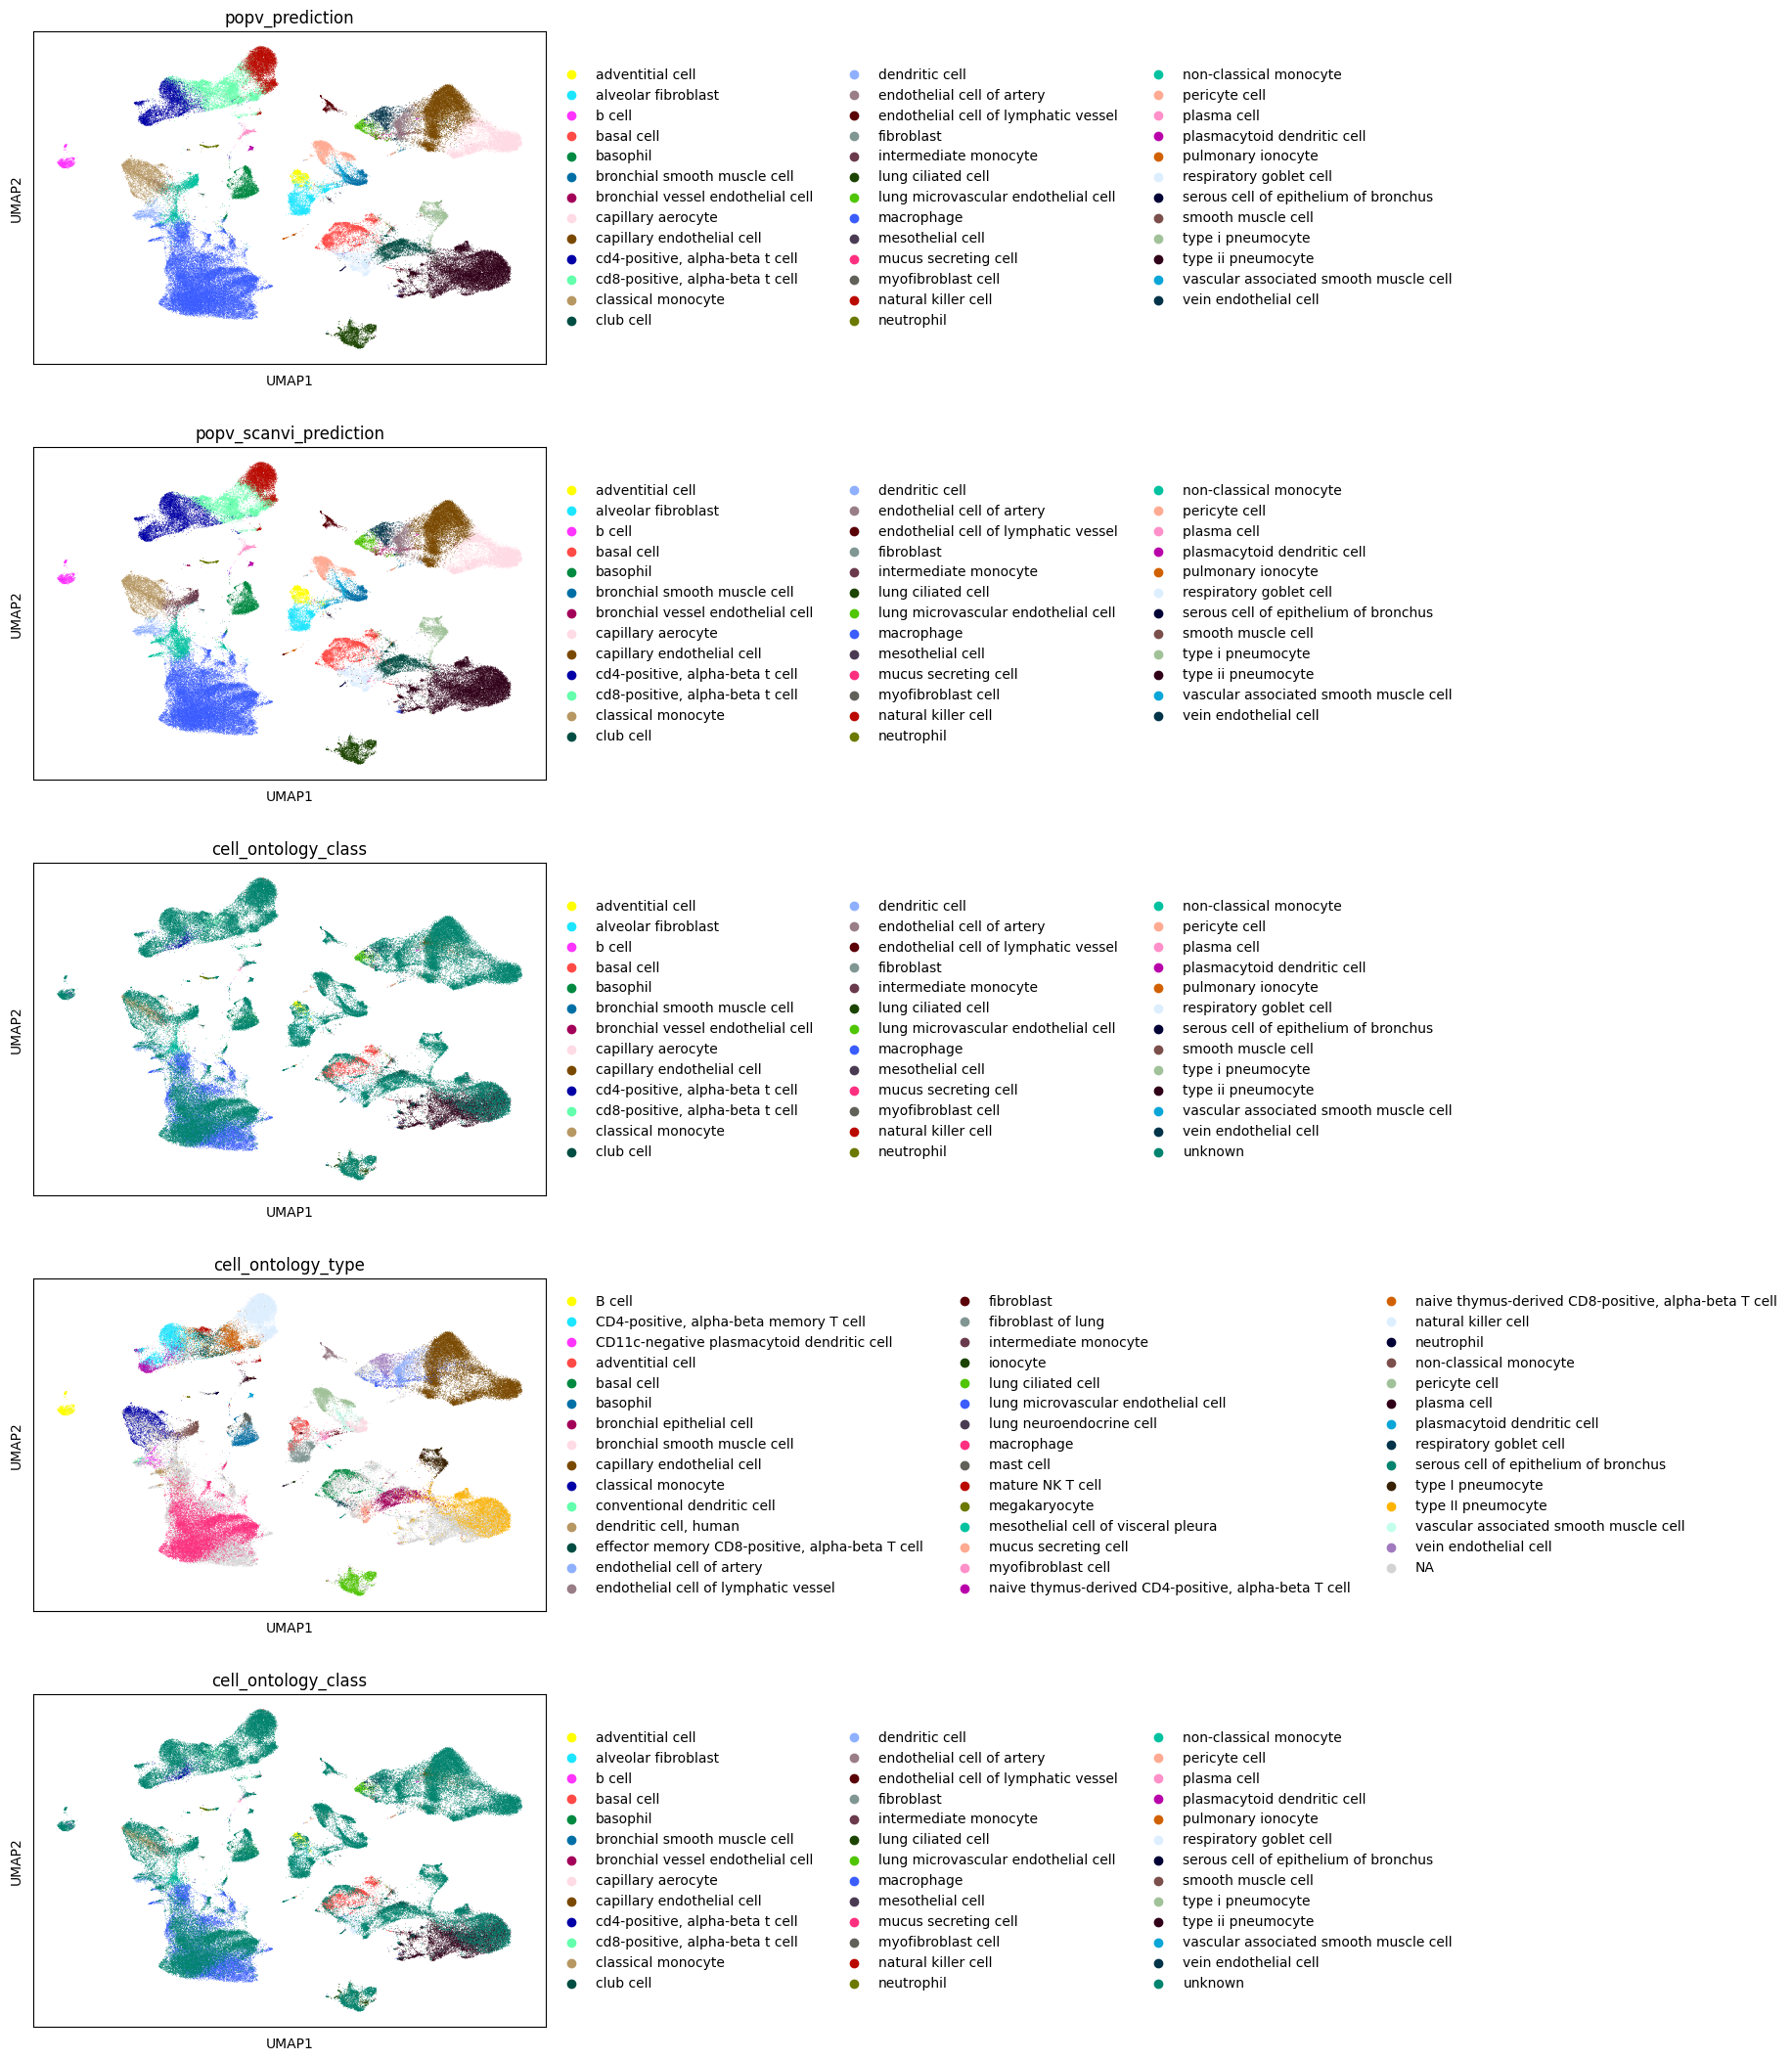

In [ ]:
adata.obsm['X_umap'] = adata.obsm['X_scanvi_umap_popv']

sc.pl.umap(adata,
           color=['popv_prediction', 'popv_scanvi_prediction', 'cell_ontology_type'], ncols=1)

# Step 6: Summary Statistics

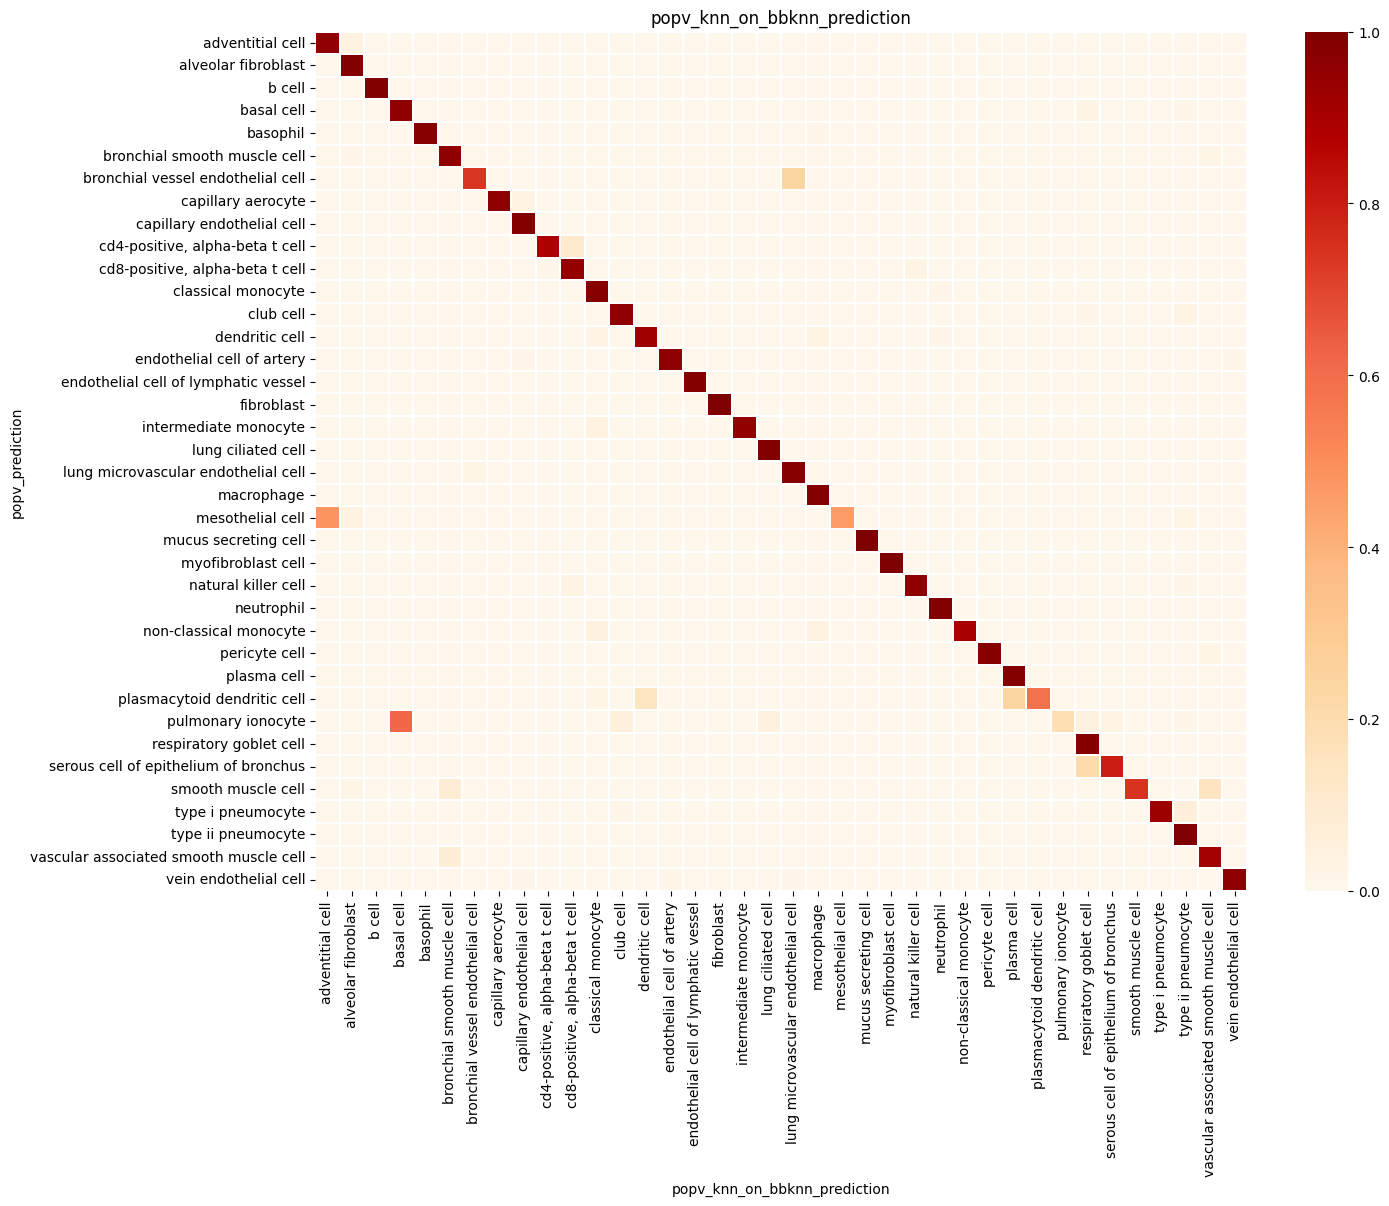

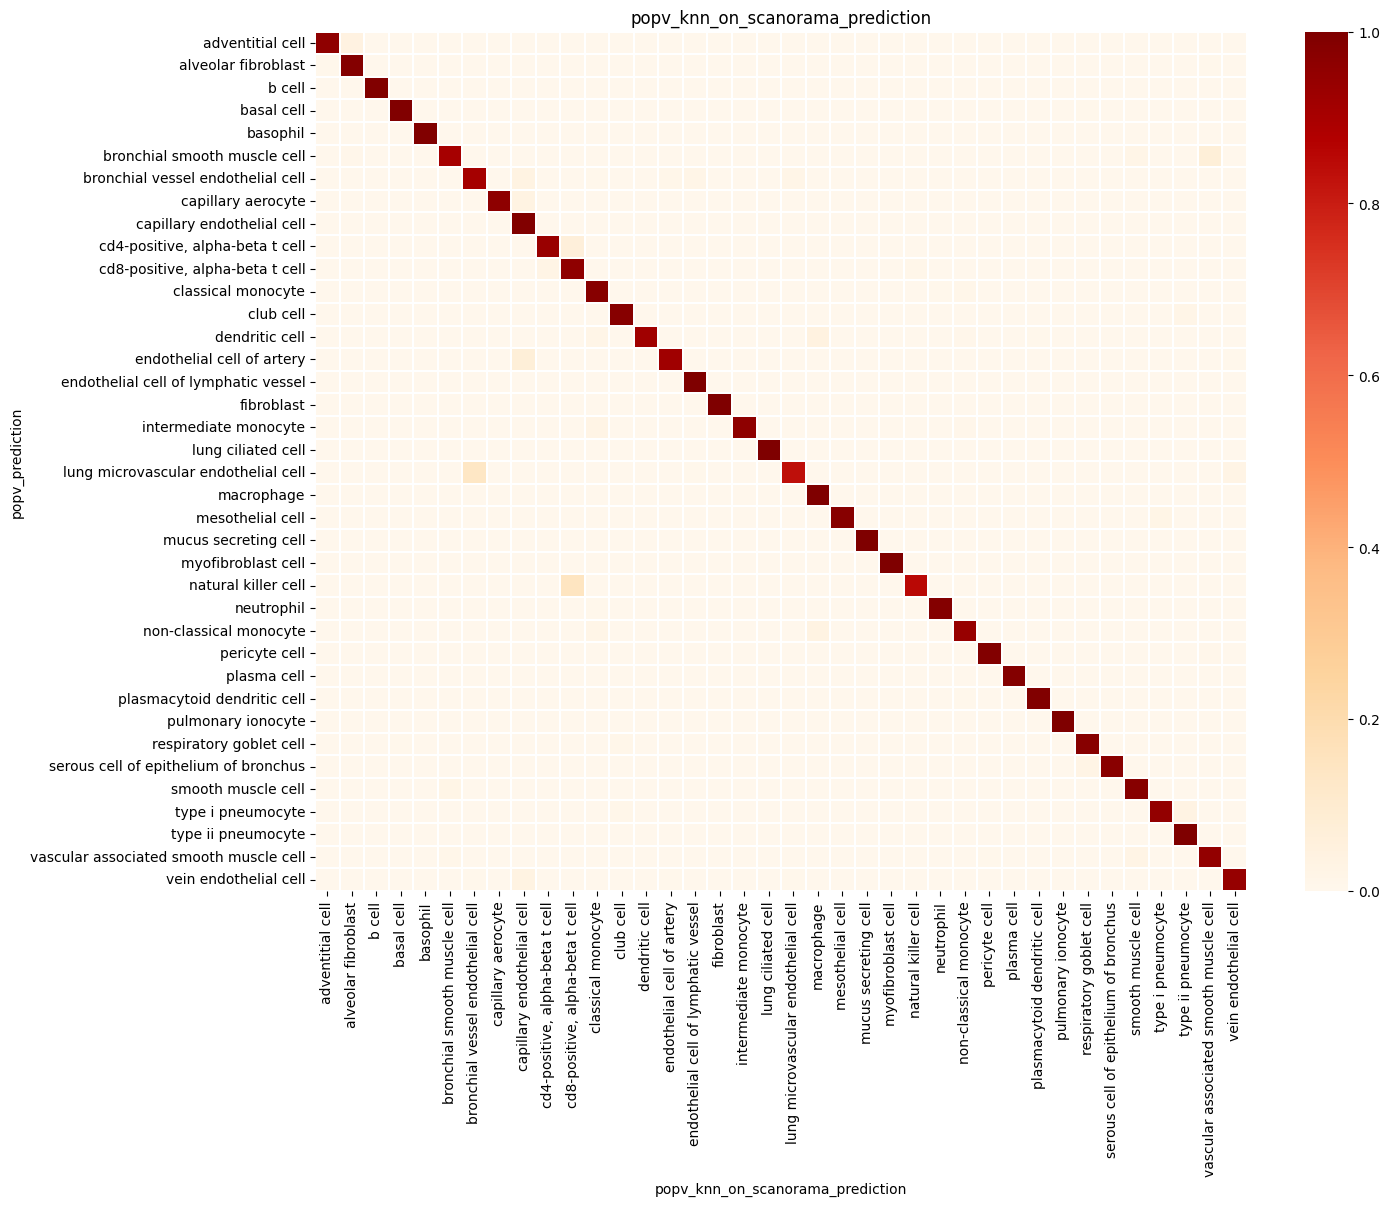

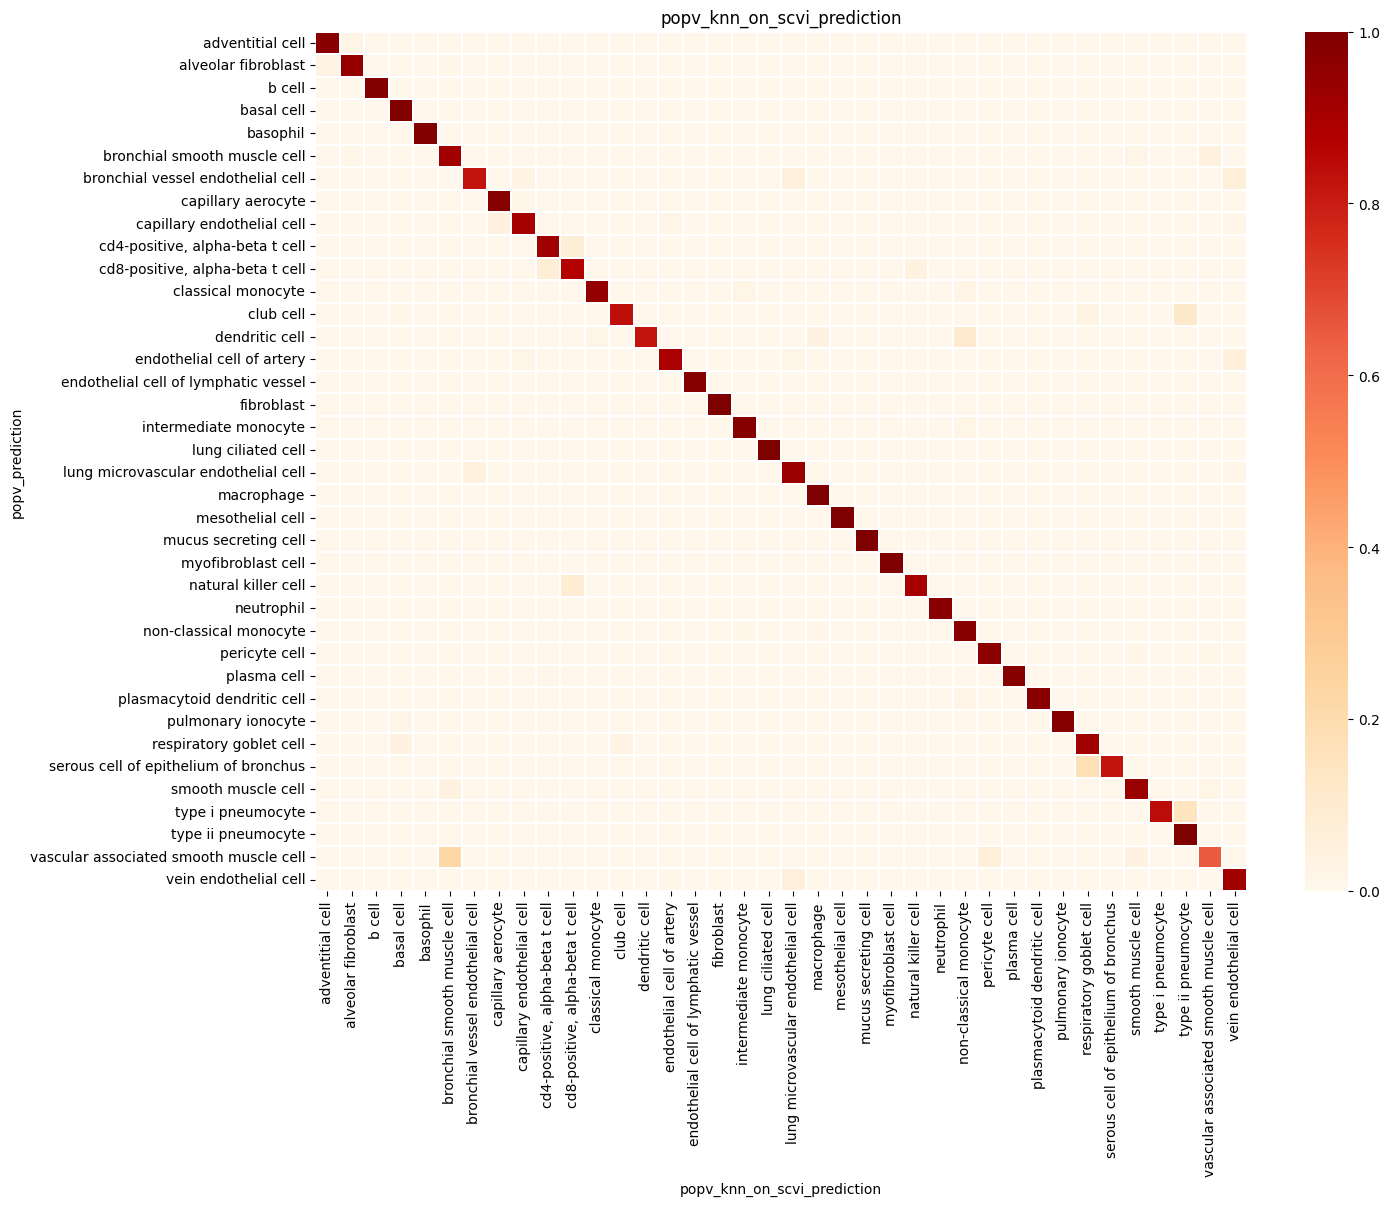

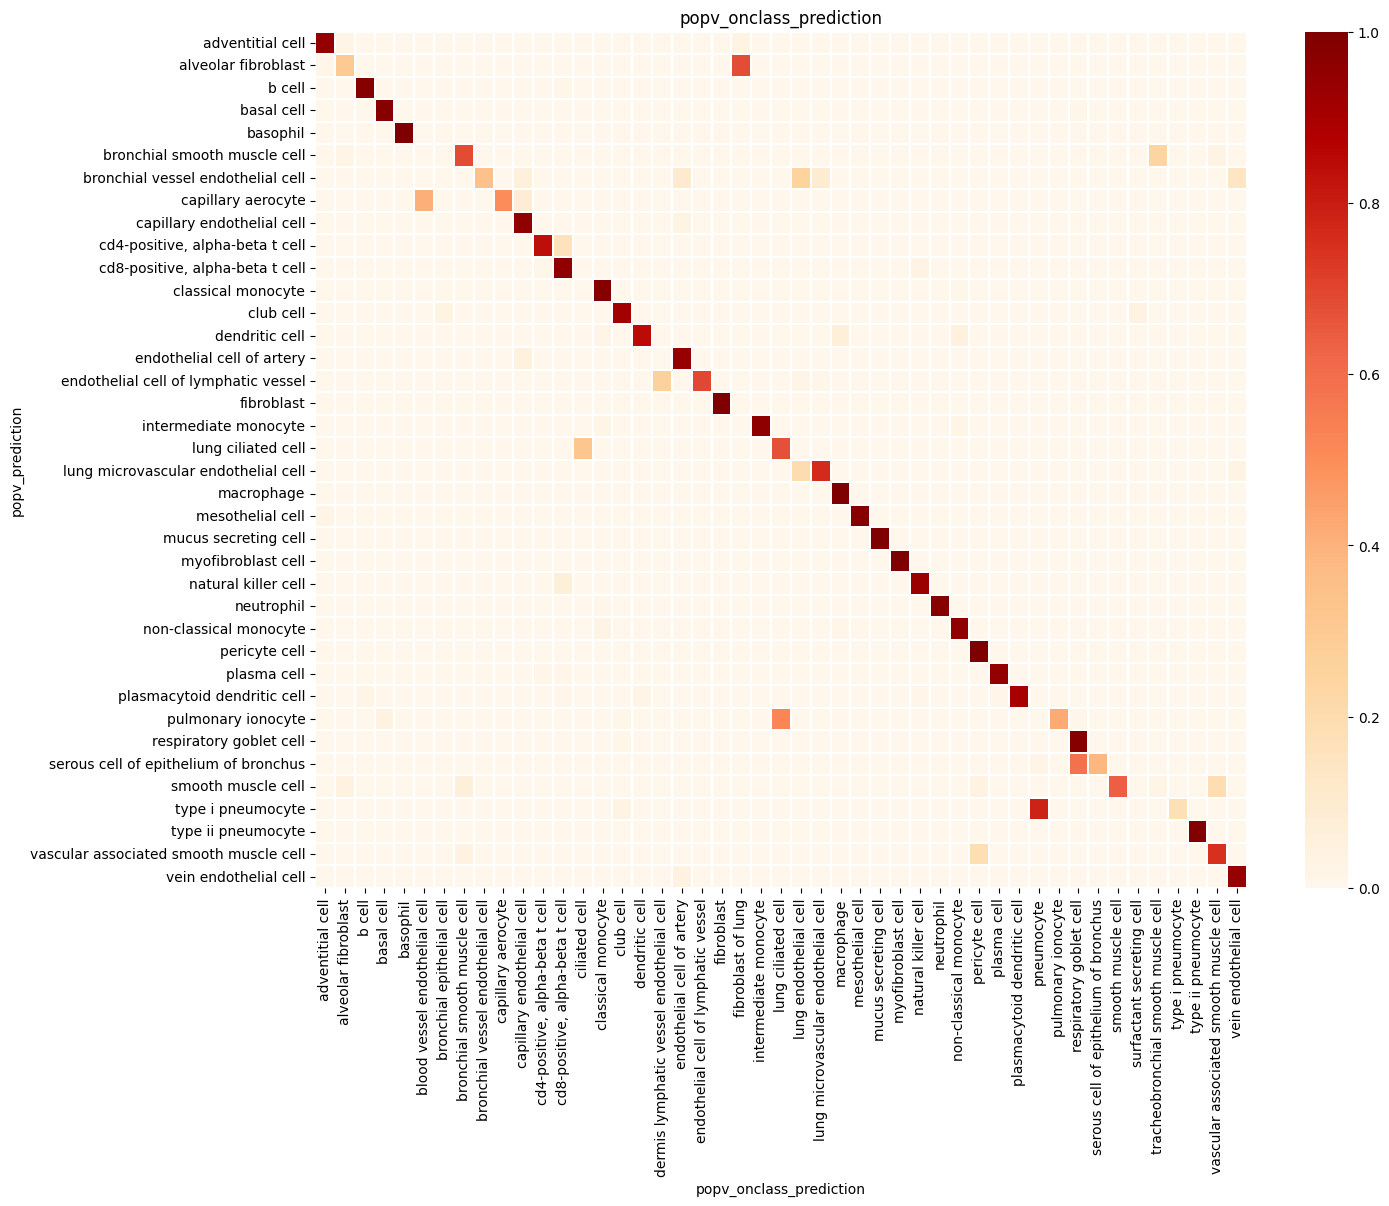

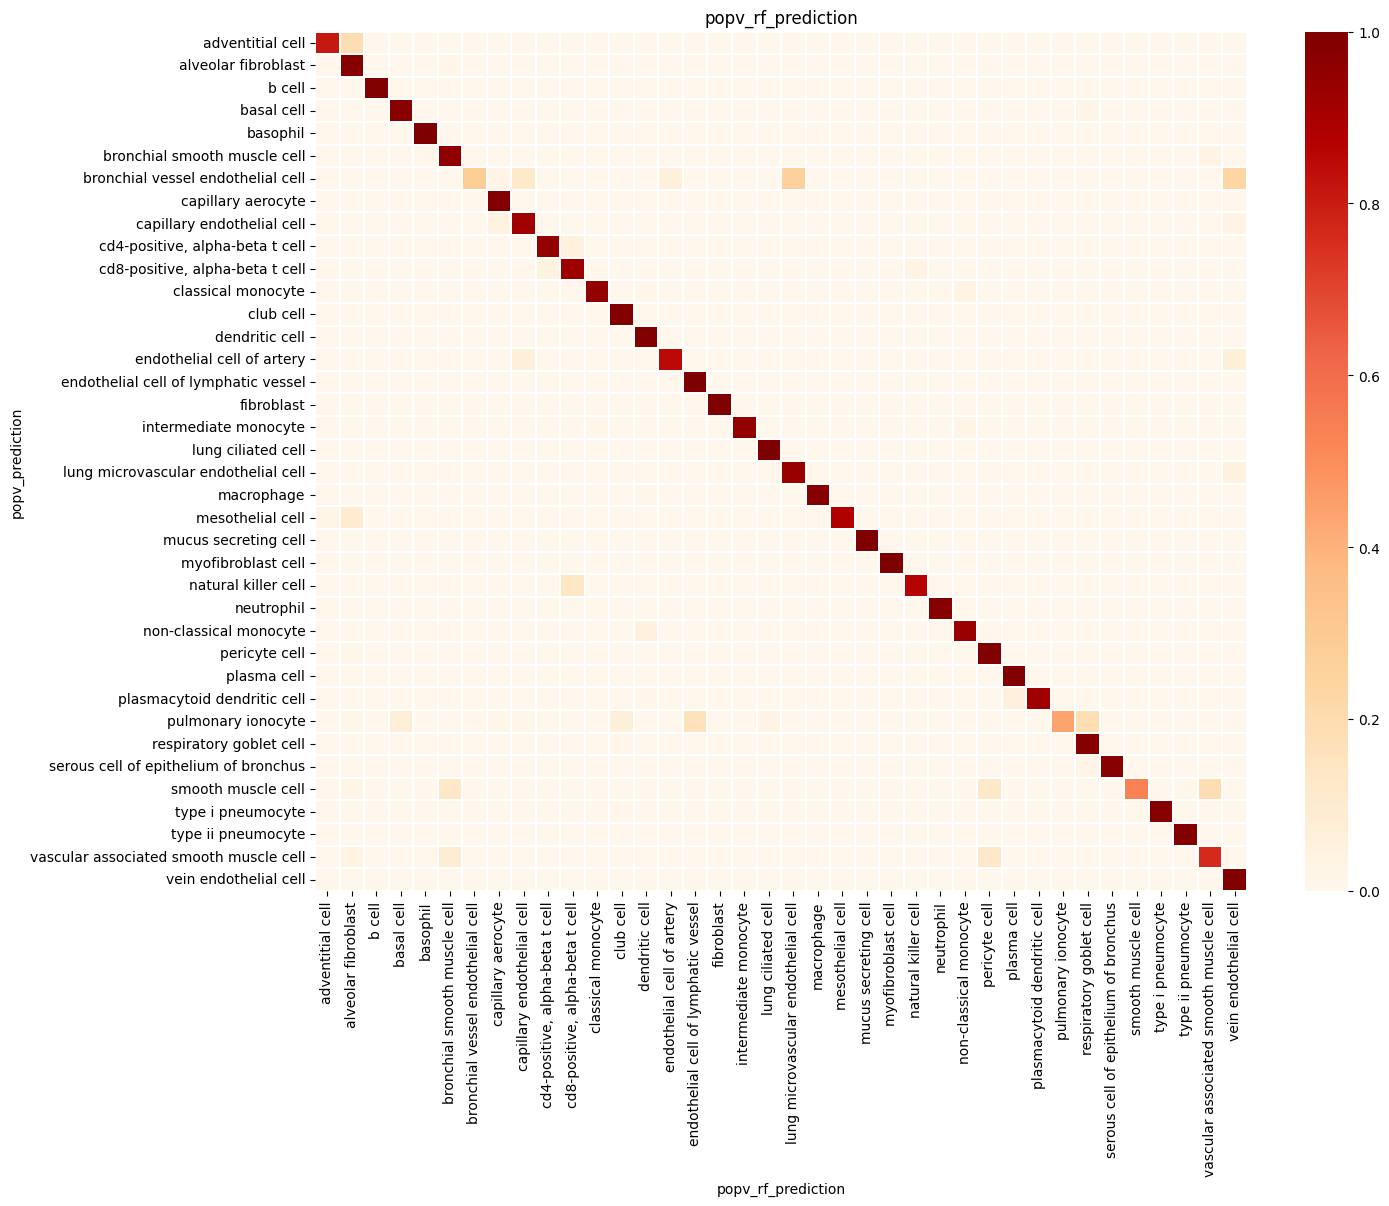

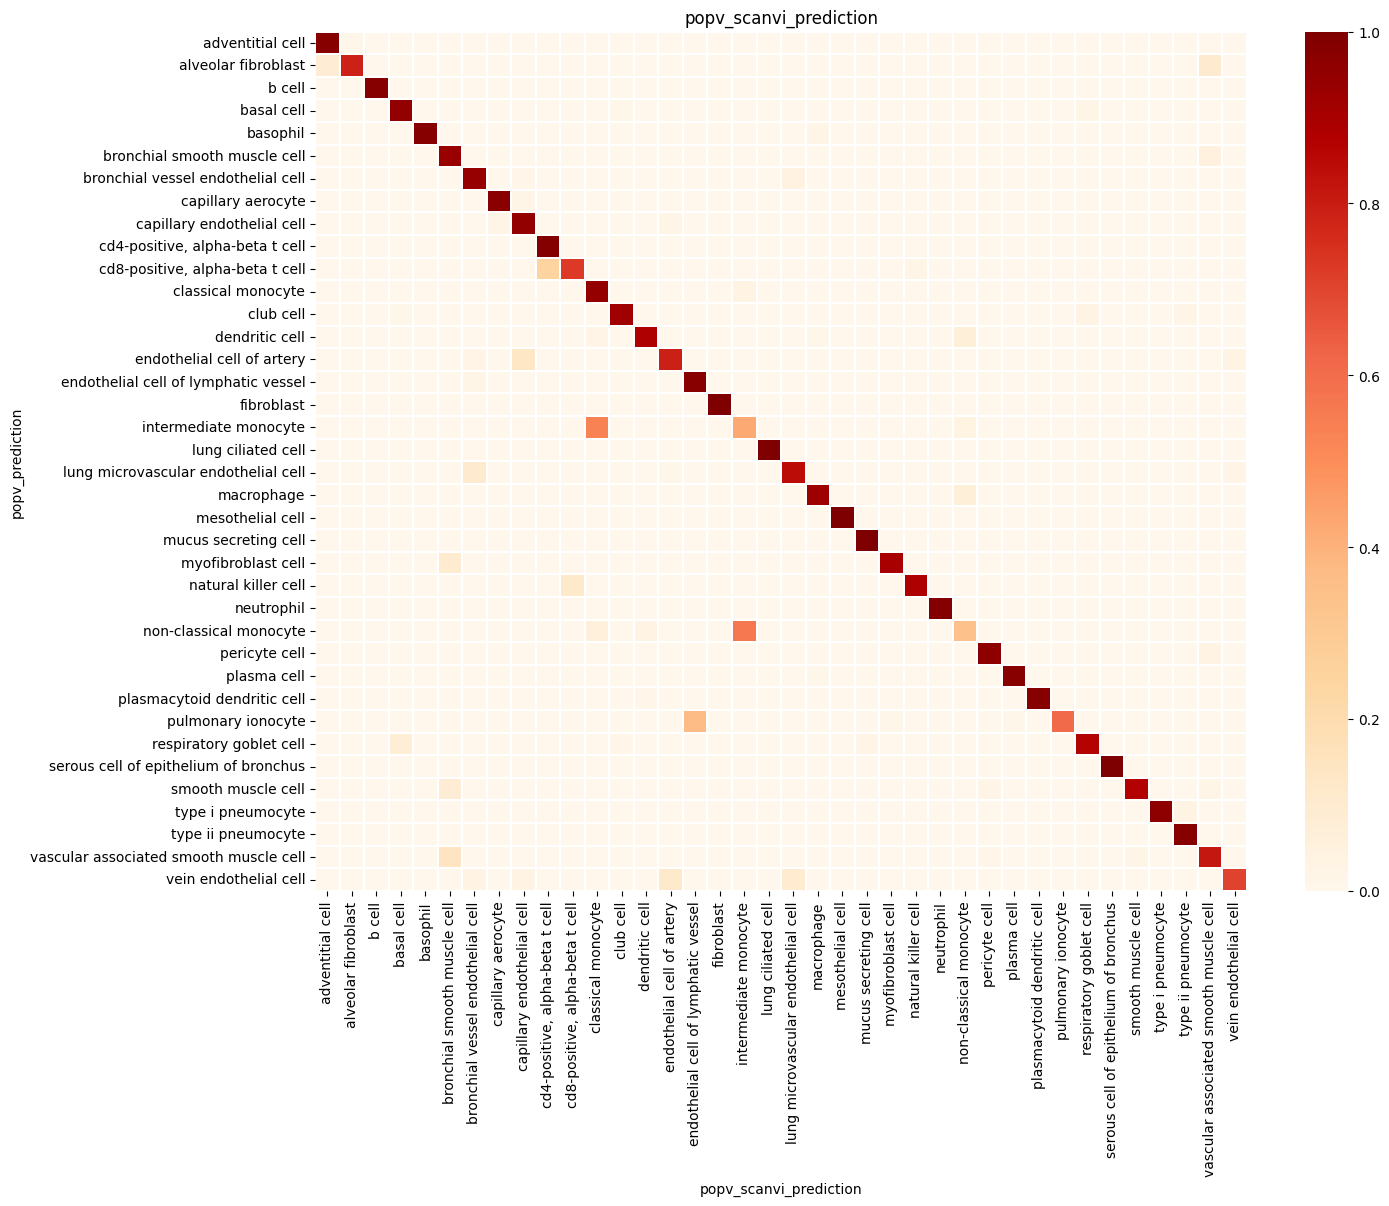

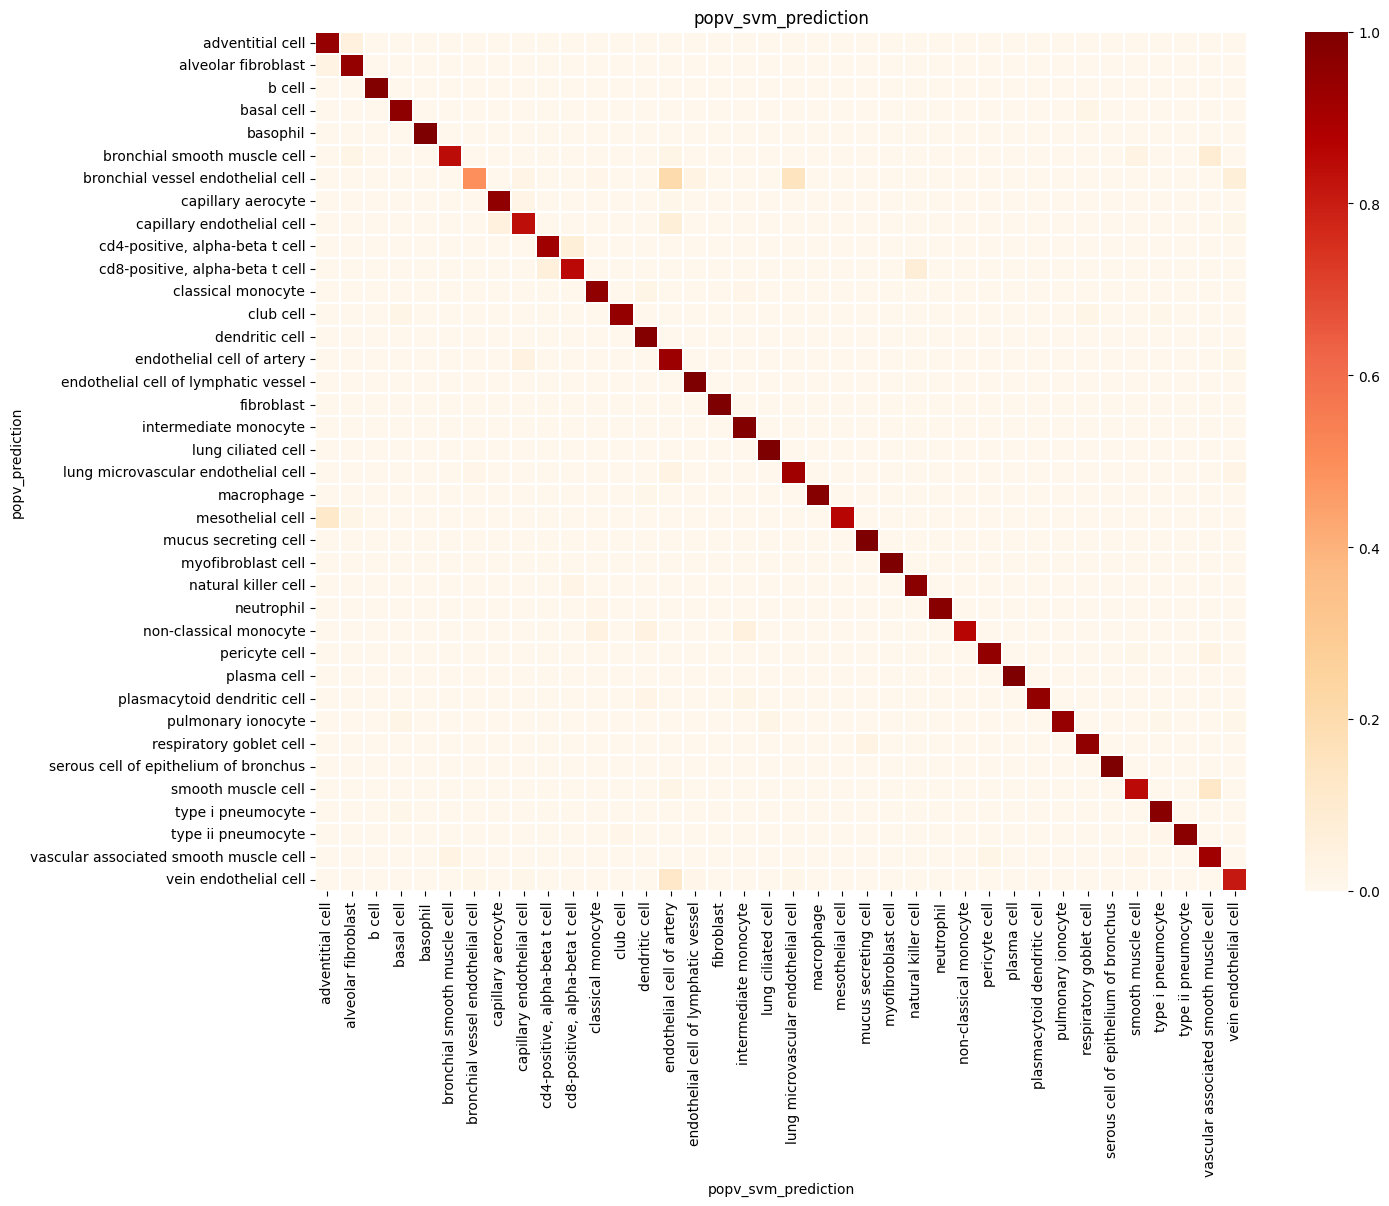

In [ ]:
popv.visualization.make_agreement_plots(adata, prediction_keys=adata.uns['prediction_keys'], save_folder=save_folder)

In [ ]:
adata

AnnData object with n_obs × n_vars = 110753 × 4000
    obs: '10X_run', 'pilot', 'tissue', 'subtissue', 'method', '10X_sample', '10X_replicate', 'notes', 'seqrun', 'donor', 'anatomical_position', '10X_barcode', 'cDNAplate', 'libraryplate', 'well', 'donor_method', 'computational_compartment_assignment', 'tissue_cell_type', 'cell_type_tissue', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', '_batch_annotation', '_labels_annotation', '_ref_subsample', 'cell_ontology_type', 'cell_ontology_id', '_dataset', 'n_counts', 'popv_knn_on_bbknn_prediction', 'popv_knn_on_scanorama_prediction', '_scvi_batch', '_scvi_labels', 'popv_knn_on_scvi_prediction', '_labels_annotation_cell_ontology_id', 'popv_onclass_prediction', 'popv_rf_prediction', 'subsampled_labels', 'popv_scanvi_prediction', 'popv_svm_prediction', 'popv_majority_vote_prediction', 'popv_majority_vote_score', 'popv_prediction', 'popv_prediction_score', 'popv_prediction_depth'
    var: 'n_counts', 'highly_varia

In [ ]:
adata.obs['subsampled_labels'].value_counts()

unknown                                   100486
vein endothelial cell                        500
lung ciliated cell                           500
basal cell                                   500
basophil                                     500
type ii pneumocyte                           500
respiratory goblet cell                      500
capillary aerocyte                           500
capillary endothelial cell                   500
cd4-positive, alpha-beta t cell              500
cd8-positive, alpha-beta t cell              500
classical monocyte                           500
club cell                                    500
non-classical monocyte                       500
macrophage                                   500
lung microvascular endothelial cell          485
adventitial cell                             373
alveolar fibroblast                          324
dendritic cell                               316
intermediate monocyte                        252
pericyte cell       

<AxesSubplot: title={'center': 'PopV Prediction Score'}, xlabel='Score', ylabel='Frequency'>

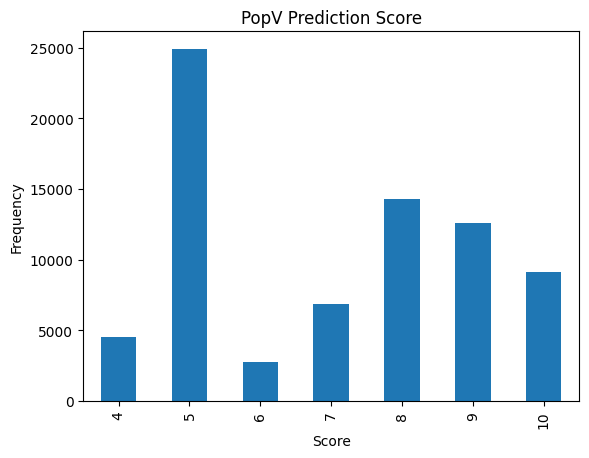

In [ ]:
popv.visualization.prediction_score_bar_plot(adata, popv_prediction_score="popv_prediction_depth")

<AxesSubplot: title={'center': 'PopV Prediction Score'}, xlabel='Score', ylabel='Frequency'>

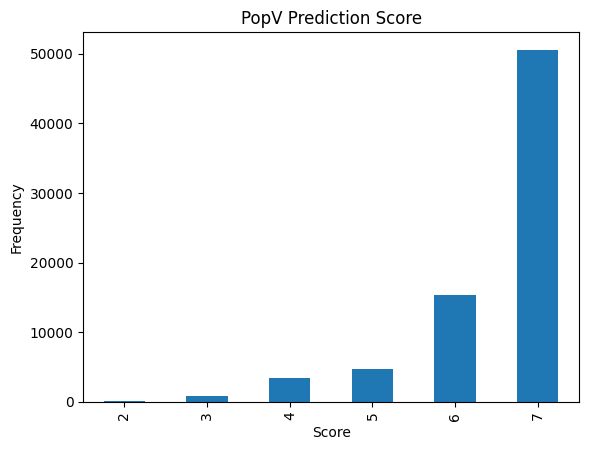

In [ ]:
popv.visualization.prediction_score_bar_plot(adata, popv_prediction_score="popv_prediction_score")

<AxesSubplot: ylabel='Mean Agreement'>

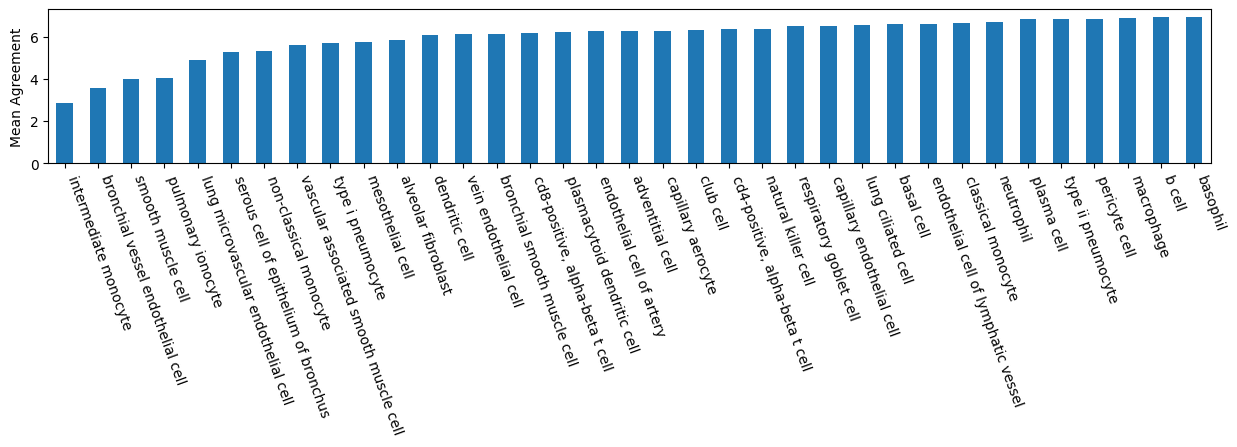

In [ ]:
popv.visualization.agreement_score_bar_plot(adata)

### Cell type proportion plot

<AxesSubplot: ylabel='log Celltype Abundance'>

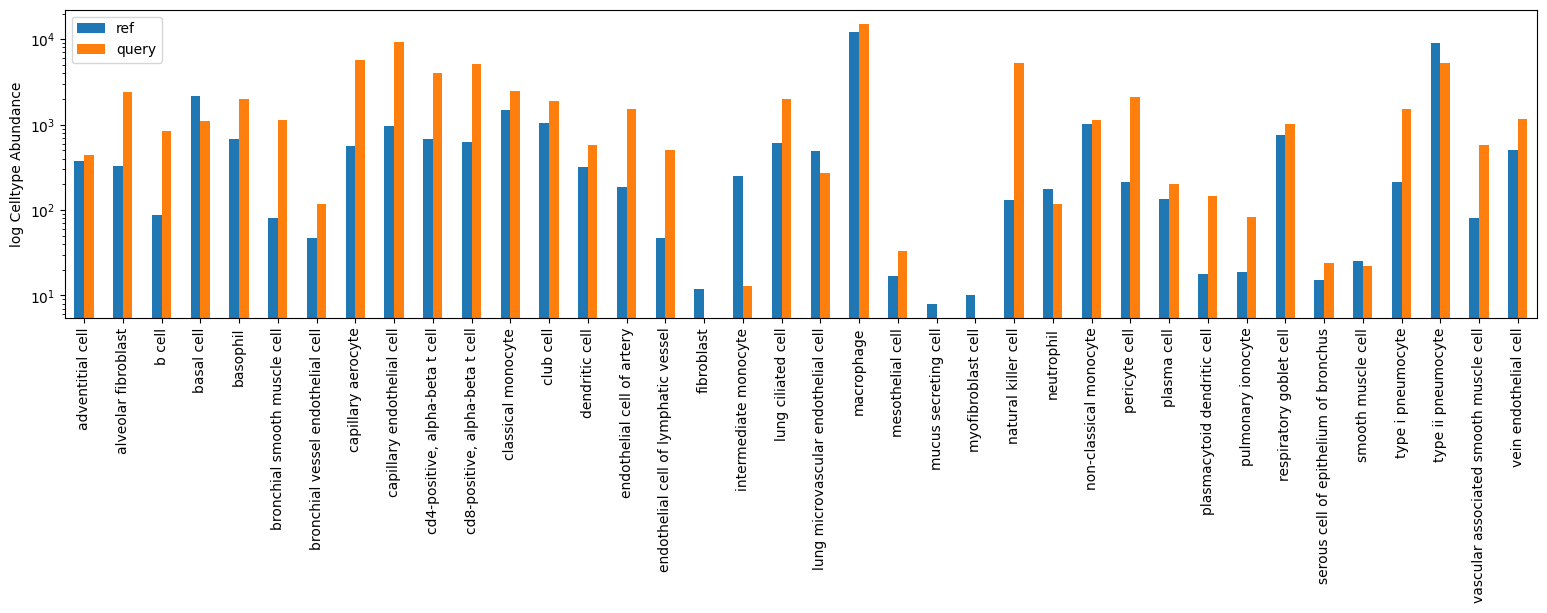

In [ ]:
popv.visualization.celltype_ratio_bar_plot(adata)